# Project

This notebook will go though the various aspects of iteration through the various python scripts used as part of this project to analyse data from [Met Éireann](https://www.met.ie/climate/available-data/historical-data) from Belmullet weather station. This including plotting with `matplotlib` and `seaborn` to predicting rainy day using logistic regression with `sklearn`. 

## Section 1 - Importing modules and initial data processing

There were a lot of data processing operations that were needed so some parts have analysis and mixed data operations due to errors being found during analysis. 

Initially all data operations were done with class variables imported from the `data_processing.py` script, but due to whitespace in nearly 18% of rows, separate functions had to made so functions were taken from a combination of class variables in `data_processing.py` or separate functions within the `python_functions.py` script. An additional Jupyter Notebook `research.ipynb` was created to show all the separate whitespace errors as it was taking up a lot of room within this Jupyter Notebook. More advanced imputation methods could have being used, but ultimately a lot of the columns were not missing at random so affected rows were removed. 

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import python_scripts.project_functions as pf
import python_scripts.data_processing as dp 
from pmdarima import auto_arima

plt.style.use('seaborn-v0_8')

In [2]:
# unzip the data and save it to the data folder
zipped_data = 'data\\hly2375.zip'
dst_dir = 'data\\'

# Unzip the combined zip file
with zipfile.ZipFile(zipped_data, 'r') as zip_ref:
    zip_ref.extractall(dst_dir)

In [3]:
pf.extract_zip('data\\hly2375.zip', 'data\\')

In [4]:
# setting low_memory to false to stop guessing of column dtypes as this is a memory intensive operation for 
# such a big file
path = 'data\\hly2375.csv'
data = pd.read_csv(path, skiprows=22, low_memory=False)

print(data.shape)
print(data.head())

# sample the data to make it easier to work with for testing operations 
# data = data_.sample(n=25000, random_state=42) 

(597898, 21)
                date  ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
0  16-sep-1956 15:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1  16-sep-1956 16:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
2  16-sep-1956 17:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
3  16-sep-1956 18:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
4  16-sep-1956 19:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

   ...  ind.3  wdsp ind.4  wddir ww  w  sun    vis clht clamt  
0  ...      1     0     1      0  1  2  0.1  16000  200     5  
1  ...      1     0     1      0  1  1  0.1  24000  999     4  
2  ...      1     0     1      0  3  1  0.4  19000   90     5  
3  ...      1     0     1      0  1  1  0.0  30000   45     4  
4  ...      1     0     1      0  3  2  0.0  28000   40     7  

[5 rows x 21 columns]


In [5]:
print(np.min(data.date),np.max(data.date))
# the first year is 1956, and the last date is in December 2024 so need to add the date column as the index. 

01-apr-1957 00:00 31-oct-2024 23:00


In [6]:
print(data.dtypes)

date      object
ind        int64
rain     float64
ind.1      int64
temp     float64
ind.2      int64
wetb     float64
dewpt    float64
vappr    float64
rhum       int64
msl      float64
ind.3      int64
wdsp      object
ind.4      int64
wddir     object
ww        object
w         object
sun       object
vis       object
clht      object
clamt     object
dtype: object


Lots of these datatypes will be need to be converted. On inspection both `w` and `ww` will not be kept as are categorical columns and there is enough data within the other integer columns and float type columns. A recap of the columns are shown below;

The columns of data are (retrieved from `data/KeyHourly.txt`);

| ID                      | ELEMENT          |   UNIT            
| :-------- | :-------: | -------: |
| rain  | Precipitation Amount    |       mm           |
|temp    |   	Air Temperature 	 |                           °C |
|wetb	|	Wet Bulb Air Temperature	|		            °C|
|dewpt	|	Dew Point Air Temperature	|		°C	|	                 
|vappr	|	Vapour Pressure				|			        hpa |
|rhum	|	Relative Humidity			|			        % |
|msl	|	    Mean Sea Level Pressure	|					    hPa |
|wdsp	|	Mean Hourly Wind Speed		|				    kt |
|wddir	|	Predominant Hourly wind Direction		|		deg |
|ww		  |  Synop Code Present Weather - decode below | decode below |
|w		 |   Synop Code Past Weather - decode below    | decode below |
|sun	|	    Sunshine duration						|        hours |
|vis	|	    Visibility							     |       m |
|clht	|	Cloud Ceiling Height - if none value is 999	|	100s feet |
|clamt	|	Cloud Amount							     |   okta |

Several data processing operations need to be completed, and initially the `date` was changed to a datetime oject and then some data extration (such as decades and season) was done. Then a `DataProcessor` class was added to make some operations easier, but then some of the functions didn't work as well with `.strftime` . For this, data extraction was done to the `date` column before changing it to a datetime object. 

Season was also extracted. While a `pd.resample` could be used, this only has quarters and not true seasons. Using similar data from Met Éireann, [Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610) break down the seasons into from the months below;
- Winter: Dec, Jan, and Feb
- Spring: Mar, Apr, and May
- Summer: Jun, Jul, and Aug
- Autumn: Sep, Oct, and Nov

Data extraction operations include
- Capitilizing name of month 
- Extracting month and season 
- Extracting year and decade

In [7]:
# firstly capitalise the first letter of month
# this makes the data more readable and easier to work with for other operations and analysis

# Apply the function to the date column
data['date'] = data['date'].apply(pf.capitalize_month)

print(data.head())

                date  ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
0  16-Sep-1956 15:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1  16-Sep-1956 16:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
2  16-Sep-1956 17:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
3  16-Sep-1956 18:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
4  16-Sep-1956 19:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

   ...  ind.3  wdsp ind.4  wddir ww  w  sun    vis clht clamt  
0  ...      1     0     1      0  1  2  0.1  16000  200     5  
1  ...      1     0     1      0  1  1  0.1  24000  999     4  
2  ...      1     0     1      0  3  1  0.4  19000   90     5  
3  ...      1     0     1      0  1  1  0.0  30000   45     4  
4  ...      1     0     1      0  3  2  0.0  28000   40     7  

[5 rows x 21 columns]


Setting the `date` column to be index. In a similar fashion to [here](https://github.com/EllenMcG/PFDA/blob/main/assignments/assignment_6_weather.ipynb). This is done to view this time series data. There appears to be no missing datetimes. 

In [8]:
# Apply the function to add month and season columns
data = pf.add_month_and_season(data)

In [9]:
data = pf.add_year_and_decade(data)
# print(data.head())


In [10]:
# setting index to date using the DataProcessor class via the data_processing module
processor = dp.DataProcessor(data)
processor.convert_to_datetime('date')
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  ww  w  sun    vis clht clamt month  season  \
date                         ...                                               
1956-09-16 15:00:00  1026.7  ...   1  2  0.1  16000  200     5   Sep  Autumn   
1956-09-16 16:00:00  1026.6  ...   1  1  0.1  24000  999     4   Sep  Autumn   
1956-09-16 17:00:00  1026.4  ...   3  1  0.4  19000   90     5   Sep  Autumn   
1956-09-16 18:00:00  1026.5  ...   1  1

## Section 2 - Comparison with a subset of data (used for testing)

While a `pd.resample` could be used, this only has quarters and not true seasons. Using similar data from Met Éireann, [Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610) break down the seasons into using the months below;
- Winter: Dec, Jan, and Feb
- Spring: Mar, Apr, and May
- Summer: Jun, Jul, and Aug
- Autumn: Sep, Oct, and Nov
This approach was taken. Then a subsampled dataset was taken (`data_subsampled`) to see how it compares with the full dataset. 


In [11]:
data_subsampled = data.sample(n=1000, random_state=42)
print(data_subsampled.head())
print(data_subsampled.shape)

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1963-04-13 11:00:00    0   0.2      0   7.8      0   5.8    3.0    7.6    72   
1979-08-19 04:00:00    2   0.0      0  12.6      0  11.6   11.0   12.8    88   
1970-06-12 23:00:00    2   0.0      0  14.4      0  14.1   14.0   15.8    97   
2001-02-16 15:00:00    0   0.0      0   8.0      0   6.6    4.8    8.6    80   
1962-01-22 08:00:00    0   0.0      0   5.6      0   3.5    0.0    6.2    68   

                        msl  ...  ww   w  sun    vis clht clamt month  season  \
date                         ...                                                
1963-04-13 11:00:00  1009.1  ...  25   8  0.8  19000   19     6   Apr  Spring   
1979-08-19 04:00:00  1019.7  ...  50   5  0.0   3000    2     8   Aug  Summer   
1970-06-12 23:00:00  1018.6  ...  50   5  0.0   3200    4     8   Jun  Summer   
2001-02-16 15:00:00  1037.2  ...  

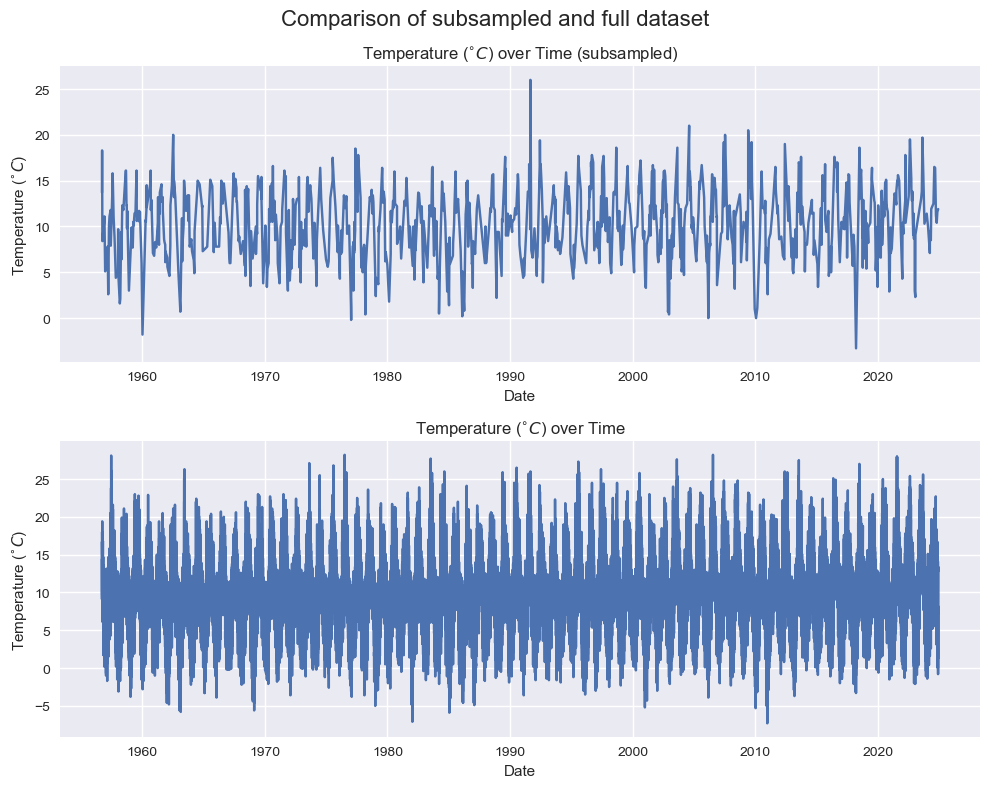

In [12]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled and full dataset', fontsize=16)

sns.lineplot(data=data_subsampled,x=data_subsampled.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')

sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

The full dataset is quite hard to view, so will look at further subsampling methods (i.e. downsampling)

## Section 3 Subsampling 
There is a seasonality element to this plot, which is easier to see in the subsampled data. There is too much data in the full dataset to view these processes. A `.resampe` method will be used on the origional dataset `data` and downsample it to month. 

The resampling method failed as some columns are of the type object and returned the error `TypeError: agg function failed [how->mean,dtype->object]` which can be fixed using some of the `DataProcessor` methods. 

Before this, the whitespace in some columns needed to be fixed (this will be investigated with `wdsp` first). All other column analysis of whitespace is contained within `research.ipynb`. The whitespace data is not being captured by the `isnull()` method as this captures `NaN` so conversion maybe needed. 


In [13]:
# investigation of wdsp column

unique = data['wdsp'].unique()
print(unique)


['0' '9' '7' '4' '6' '8' '11' '12' '10' '5' '13' '14' '15' '18' '19' '17'
 '16' '21' '24' '22' '26' '20' '23' '3' '2' '1' '25' '36' '38' '34' '37'
 '29' '27' '28' '31' '30' '32' '33' '35' '41' '45' '49' '48' '43' '39'
 '40' '44' '58' '63' '47' '59' '56' '42' '46' '51' '50' '53' '55' '52'
 '54' '57' ' ']


In [14]:
missing_data = data['wdsp'].isnull().sum()
print(missing_data)

0


Looking at the below image, there is white space at the last entry, but the above code using `.isnull()` does not pick it up as a missing value as the rows with white space does not have a `NaN` value. 

![image of white space for a in place of data](img/whitespace.png)

The below code checks for whitespace in the `wdsp` column and prints it out. Since there is only one value missing a `NaN` value can be inserted and checked with the `.isnull` method. 

```python
missing_whtspace = data['wdsp'].str.startswith(' ').sum()
print(missing_whtspace)
1
```

This `NaN` value can then be filled, in this case `.bfill` was used given so little values are actually missing such a big dataset (>0.5 million rows). 

In [15]:
missing_whtspace = data['wdsp'].str.startswith(' ').sum()
print(missing_whtspace)

1


In [16]:
data['wdsp'] = np.where(data['wdsp'].str.startswith(' '), np.nan, data['wdsp'])
is_null = data['wdsp'].isnull().sum()
print(is_null)

1


In [17]:
data['wdsp'] = data['wdsp'].bfill()

In [18]:
unique_2 = data['wdsp'].unique()
print(unique_2)

['0' '9' '7' '4' '6' '8' '11' '12' '10' '5' '13' '14' '15' '18' '19' '17'
 '16' '21' '24' '22' '26' '20' '23' '3' '2' '1' '25' '36' '38' '34' '37'
 '29' '27' '28' '31' '30' '32' '33' '35' '41' '45' '49' '48' '43' '39'
 '40' '44' '58' '63' '47' '59' '56' '42' '46' '51' '50' '53' '55' '52'
 '54' '57']


In [19]:
# convert to int
processor.convert_to_int('wdsp')

### Section 3.1 Data processing of missing data (whitespace)

Further investigation of object columns showed the following;
- `wwdir` was missing only 8 values.
- `ww` missing > 100000 rows of data (108018). Backfilling this would not be an option so a method of impution would be needed. Since this classification column won't be used this can be deleted.
- `w` missing > 100000 rows of data (108018). Backfilling this would not be an option so a method of impution would be needed. Since this classification column won't be used this can be deleted. The same rows missing for `ww` are missing for `w`.
- `vis` is missing > 100000 rows of data (108052). This is not a classification column, and would be an interesting column for modelling. 
- `clht` is missing > 100000 rows of data (108042). As above, backfilling is used. The `KeyHourly.txt` file shows that values decoded as 999 are none, so this needs to be converted to 0.
- `clamt` is missing > 100000 rows of data (108042). As above, backfilling is used. 
- `sun` is missing > 100000 rows of data (107952)

These columns are missing a lot of data (`wwdir`, `vis`,`clht`, `clamt`, and `sun`) that backfilling would not be an option so a method of impution would be needed. Since this classification column won't be used this can be deleted. A lot of these rows are missing the same columns, so may not be missing at random. Backfilling would be more deserible than forward filling, but given 1/6th of data is missing a more robust imputation method would be good. Given the vaules have a big range, dropping these columns may be more desirable.

Both `ww` and `w` can be dropped as they are classification columns and won't be used further. 

Data shape has being reduced from 597898 to 489845 (108053 or 18.1%) after operations of white space, but blank columns can be seen below

![blank space in columns of dataframe](img/blank.png)


```python
data.shape
(597898, 21)

columns_to_check = ['sun', 'vis', 'clht', 'clamt', 'wddir'] 

for column in columns_to_check:
     data = data[data[column] != ' ']

data.shape
(489845, 24)
```

Further information and cleaning of whitespace is documented within `research.ipynb`. However, this cuts data off after Aug 2012. These 12 years (until Dec 2024) were removed. 

In [20]:
# removing rows with missing values classed as whitespace
columns_to_check = ['sun', 'vis', 'clht', 'clamt', 'wddir'] 

for column in columns_to_check:
     data = data[data[column] != ' ']

# Now 'data' is filtered for all specified columns

In [21]:
# replace values of 999 with 0 for clht
data['clht'] = np.where(data['clht'] == '999', '0', data['clht'])

In [22]:
data['sun'] = pd.to_numeric(data['sun'])

In [23]:
columns_to_check_int = ['vis', 'clht', 'clamt', 'wddir'] 
for column in columns_to_check_int:
    data[column] = data[column].astype(int)

In [24]:
# drop columns w and ww as classificaiton columns are not needed
data.drop(columns=['w','ww'], axis=1)

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,...,ind.4,wddir,sun,vis,clht,clamt,month,season,year,decade
date,,,,,,,,,,,,,,,,,,,,,
1956-09-16 15:00:00,0,0.0,0,14.4,0,12.1,10.0,12.4,76,1026.7,...,1,0,0.1,16000,200,5,Sep,Autumn,1956,1950s
1956-09-16 16:00:00,0,0.0,0,13.9,0,11.6,9.4,11.9,75,1026.6,...,1,0,0.1,24000,0,4,Sep,Autumn,1956,1950s
1956-09-16 17:00:00,0,0.0,0,14.2,0,12.0,10.0,12.3,76,1026.4,...,1,0,0.4,19000,90,5,Sep,Autumn,1956,1950s
1956-09-16 18:00:00,0,0.0,0,13.0,0,11.6,10.0,12.6,85,1026.5,...,1,0,0.0,30000,45,4,Sep,Autumn,1956,1950s
1956-09-16 19:00:00,0,0.0,0,12.6,0,11.7,11.1,13.1,90,1026.8,...,1,0,0.0,28000,40,7,Sep,Autumn,1956,1950s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-07 20:00:00,0,0.0,0,14.7,0,13.7,12.9,14.9,89,1019.9,...,2,30,0.4,75000,0,2,Aug,Summer,2012,2010s
2012-08-07 21:00:00,3,0.0,0,13.7,0,12.8,12.0,14.1,90,1020.7,...,2,40,0.0,75000,0,3,Aug,Summer,2012,2010s
2012-08-07 22:00:00,3,0.0,0,13.5,0,12.9,12.4,14.4,93,1020.6,...,2,50,0.0,75000,0,3,Aug,Summer,2012,2010s


In [25]:
data.describe()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,sun,vis,clht,clamt,year
count,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000,489845.000000
mean,0.802744,0.134879,0.006408,10.117657,0.020604,8.863502,7.456944,10.718319,84.054327,1012.513522,1.329559,12.880134,1.330425,195.788402,0.149068,25174.721402,31.747683,5.866409,1984.155882
std,1.164676,0.486246,0.079794,4.050031,0.267857,3.901619,4.318526,3.049523,10.141021,13.012732,0.860392,7.054515,0.860978,95.052932,0.311318,14180.209688,46.225745,2.308052,16.140151
min,0.000000,0.000000,0.000000,-7.300000,0.000000,-7.600000,-17.700000,2.400000,29.000000,943.200000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,1956.000000
25%,0.000000,0.000000,0.000000,7.400000,0.000000,6.100000,4.300000,8.300000,77.000000,1004.600000,0.000000,8.000000,0.000000,130.000000,0.000000,15000.000000,3.000000,4.000000,1970.000000
50%,0.000000,0.000000,0.000000,10.200000,0.000000,9.000000,7.900000,10.600000,86.000000,1013.800000,2.000000,12.000000,2.000000,210.000000,0.000000,24000.000000,20.000000,7.000000,1984.000000
75%,2.000000,0.000000,0.000000,13.100000,0.000000,11.800000,10.800000,12.800000,92.000000,1021.800000,2.000000,17.000000,2.000000,270.000000,0.000000,30000.000000,38.000000,8.000000,1998.000000
max,6.000000,25.900000,1.000000,28.200000,6.000000,22.900000,21.300000,25.400000,100.000000,1050.900000,6.000000,63.000000,6.000000,360.000000,1.000000,75000.000000,300.000000,8.000000,2012.000000


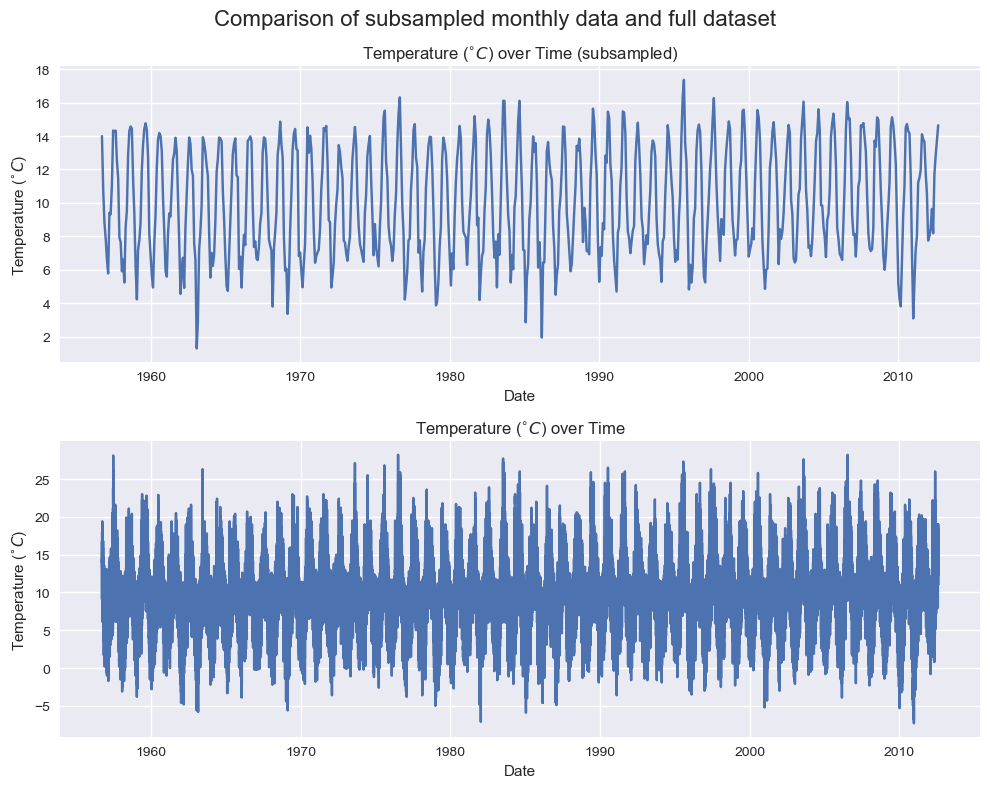

In [26]:
# resampling every month 
# adding in a second column as if sample on one column it will be a pd.Series
# and season is still an object so cant be resampled to mean
data_monthly = data[['sun','temp']].resample('ME').mean()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled monthly data and full dataset', fontsize=16)
sns.lineplot(data=data_monthly,x=data_monthly.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')
sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

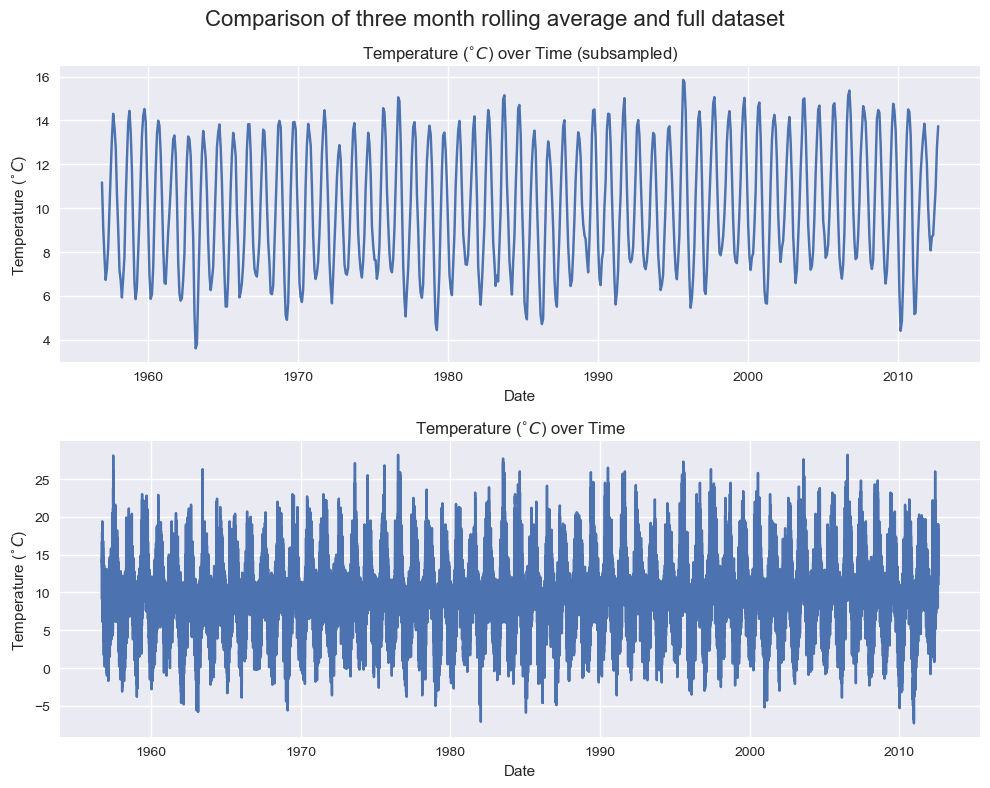

In [27]:
# resampling every month with rolling average of 3 months
# adding in a second column as if sample on one column it will be a pd.Series
# and season is still an object so cant be resampled to mean
data_monthly['temp_moving_avg'] = data_monthly['temp'].rolling(window=3).mean()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of three month rolling average and full dataset', fontsize=16)
sns.lineplot(data=data_monthly,x=data_monthly.index,y='temp_moving_avg', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')
sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

The above data showing monthly subsampled data with a 3 month rolling average (average length of season) shows that the seasonity of temperature is showing. 

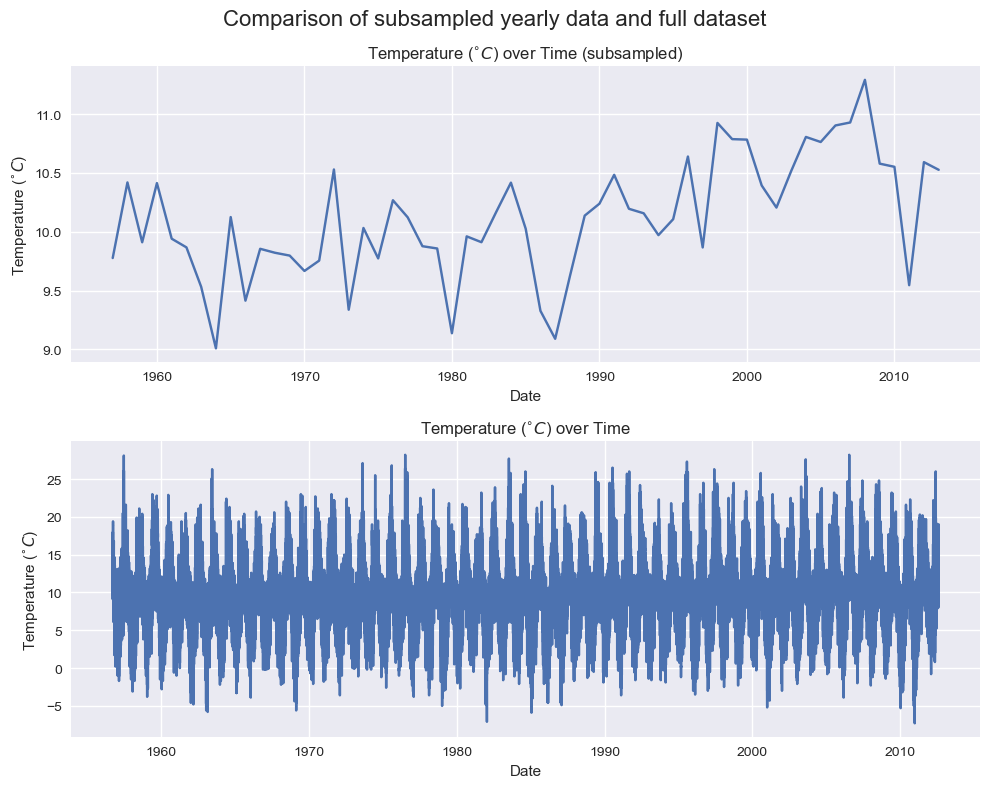

In [28]:
# resampling every year
# adding in a second column as if sample on one column it will be a pd.Series
# and season is still an object so cant be resampled to mean
data_yearly = data[['sun','temp']].resample('YE').mean()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled yearly data and full dataset', fontsize=16)
sns.lineplot(data=data_yearly,x=data_yearly.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')
sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

Unsuprizingly, the yearly downsampling has removed the deatail of seasonality, but what about min and max values. This detail is now missing and additional plots are needed to show it. 

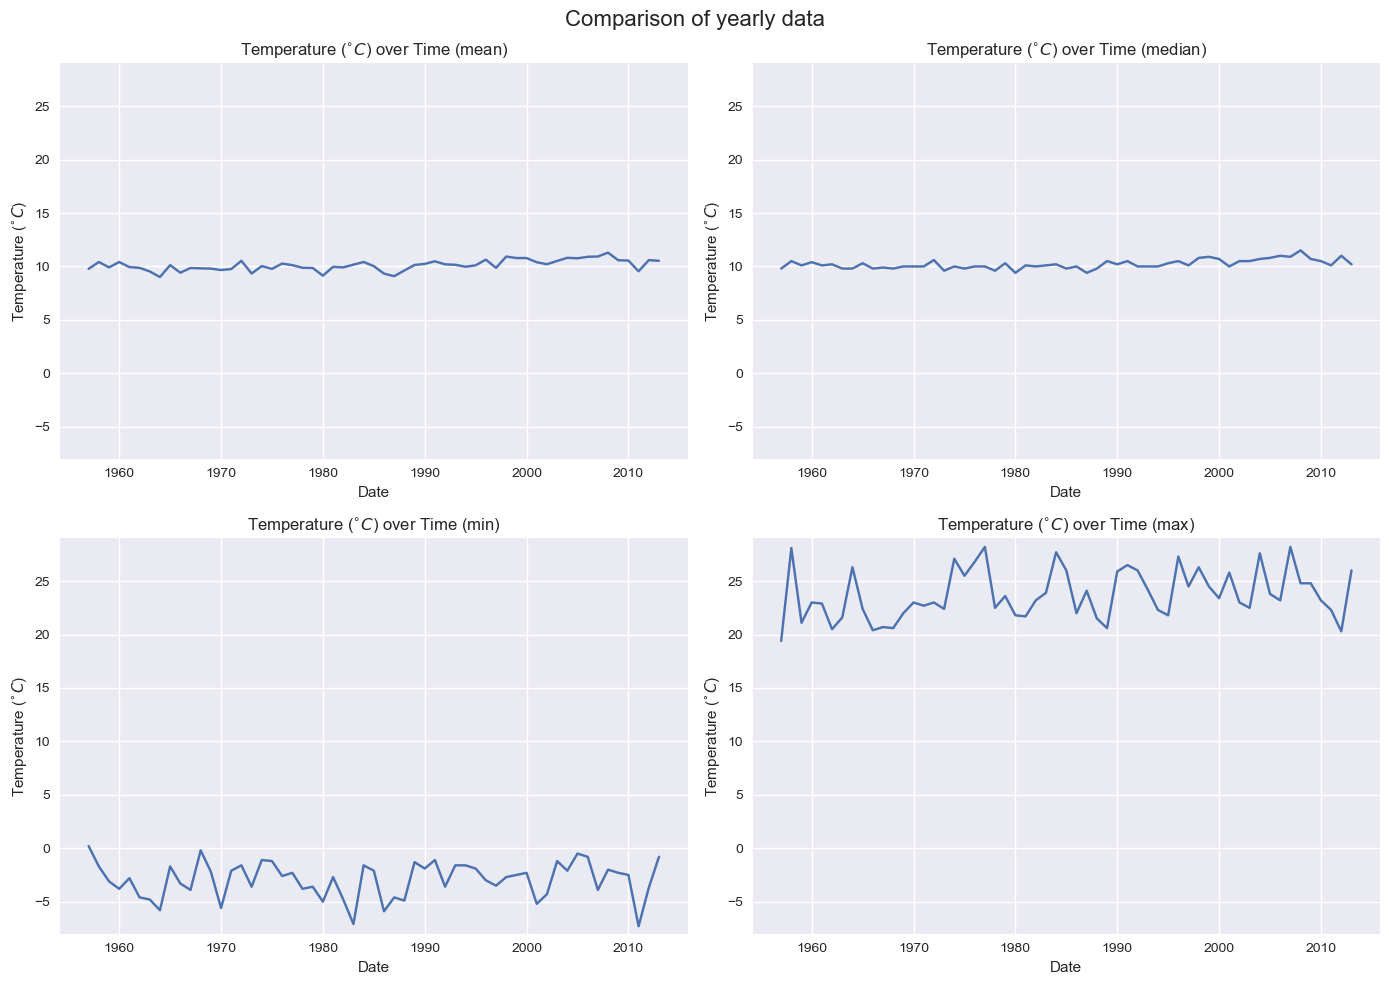

In [29]:
# resampling every year showing mean, median, min, and max
data_yearly_mean = data[['sun','temp']].resample('YE').mean()
data_yearly_median = data[['sun','temp']].resample('YE').median()
data_yearly_min = data[['sun','temp']].resample('YE').min()
data_yearly_max = data[['sun','temp']].resample('YE').max()

# Create a figure and two subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

fig.suptitle('Comparison of yearly temperature data', fontsize=16)
sns.lineplot(data=data_yearly_mean,x=data_yearly_mean.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_ylim([-8, 29])
ax1.set_title('Temperature ($^{\circ}C$) over Time (mean)')

sns.lineplot(data=data_yearly_median,x=data_yearly_median.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_ylim([-8, 29])
ax2.set_title('Temperature ($^{\circ}C$) over Time (median)')

fig.suptitle('Comparison of yearly data', fontsize=16)
sns.lineplot(data=data_yearly_min,x=data_yearly_min.index,y='temp', ax=ax3)
ax3.set_ylabel('Temperature ($^{\circ}C$)')
ax3.set_xlabel('Date')
ax3.set_ylim([-8, 29])
ax3.set_title('Temperature ($^{\circ}C$) over Time (min)')

fig.suptitle('Comparison of yearly data', fontsize=16)
sns.lineplot(data=data_yearly_max,x=data_yearly_max.index,y='temp', ax=ax4)
ax4.set_ylabel('Temperature ($^{\circ}C$)')
ax4.set_xlabel('Date')
ax4.set_ylim([-8, 29])
ax4.set_title('Temperature ($^{\circ}C$) over Time (max)')

plt.tight_layout();

## Section 4 - Seasonality 

Viewing the temperature by season by ascending decade shows highly variable data which is not suprizing as the full dataset is being used. The medians for all decades for each season (except summer) align, despite the high number of outliers. 

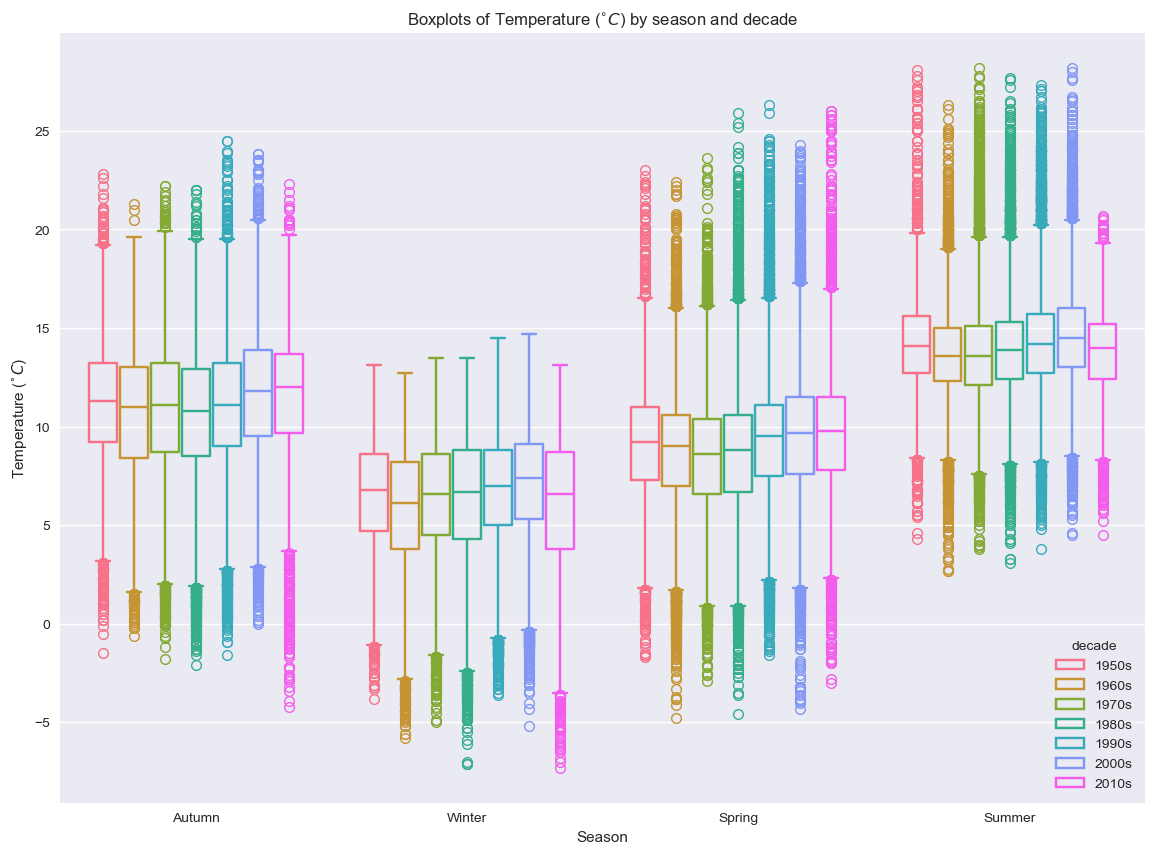

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 10))
sns.boxplot(data=data, x="season", y="temp", hue="decade",fill=False, gap=.1, ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Season')
ax1.set_title('Boxplots of Temperature ($^{\circ}C$) by season and decade');

In [31]:
# Plotting the temperature by season over time (decades)
# data = pf.add_year_and_decade(data)

## Section 5 - Power Analysis 

Power can now be calculated. `wdsp` was already converted to an datatype of type `int` (see Section 3)

In [32]:
# processor.convert_to_int('wdsp')

data['power'] = pf.calculate_power(data['wdsp'])

# adding converted wdsp column (from knots to m/s) 
data['wdsp_ms'] = data['wdsp'] * 0.514444 # small calc so not added to cleaning functions
# data['power'] = pf.calculate_power(data['wdsp'].astype(int))
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  sun    vis  clht  clamt month  season  year  \
date                         ...                                                
1956-09-16 15:00:00  1026.7  ...  0.1  16000   200      5   Sep  Autumn  1956   
1956-09-16 16:00:00  1026.6  ...  0.1  24000     0      4   Sep  Autumn  1956   
1956-09-16 17:00:00  1026.4  ...  0.4  19000    90      5   Sep  Autumn  1956   
1956-09-16 18:00:00  1026.5  ...  

In [33]:
power_by_season = data.groupby('season')['power'].agg(['mean','median','std'])
print(power_by_season)

              mean     median         std
season                                   
Autumn  151.469691  73.284218  238.010493
Spring  130.554012  57.640022  198.624408
Summer   88.131383  44.397494  126.883863
Winter  201.664570  91.530221  323.518054


In [34]:
wdsp_by_season = data.groupby('season')['wdsp_ms'].agg(['mean','median','std'])
print(wdsp_by_season)

            mean    median       std
season                              
Autumn  6.781678  6.687772  3.700886
Spring  6.528484  6.173328  3.453285
Summer  5.837920  5.658884  2.928739
Winter  7.368941  7.202216  4.166087


In [35]:
# resampling by day to see how many days are in the dataset and power above a threshold value 
wdsp_by_day = data.resample('D').agg({'wdsp_ms':'mean', 'power':'mean'})
print(wdsp_by_day.shape)
print(wdsp_by_day.head())

# there are over 20000 days in the dataset

(20416, 2)
             wdsp_ms       power
date                            
1956-09-16  0.000000    0.000000
1956-09-17  3.879765   19.164696
1956-09-18  4.051247   18.700485
1956-09-19  5.723190   55.275881
1956-09-20  9.024205  205.519092


A typical windfarm needs a cut-in wind speed of 3 - 5 m/s, i.e., the speed at which a wind turbine will start to produce electricity. 

In [36]:
min_count = (wdsp_by_day['wdsp_ms'] >= 3).sum()
normal_count = (wdsp_by_day['wdsp_ms'] > 5).sum()

min_days = min_count / wdsp_by_day.shape[0]
normal_days = normal_count / wdsp_by_day.shape[0]
print(min_days, normal_days)

0.9008130877742947 0.6711402821316614


In [37]:
print(f'The percentage of days with wind speeds greater than or equal 3 m/s is {min_days:.2%} while the ' 
      f'percentage of days with wind speeds greater than 5 m/s is {normal_days:.2%}')

The percentage of days with wind speeds greater than or equal 3 m/s is 90.08% while the percentage of days with wind speeds greater than 5 m/s is 67.11%


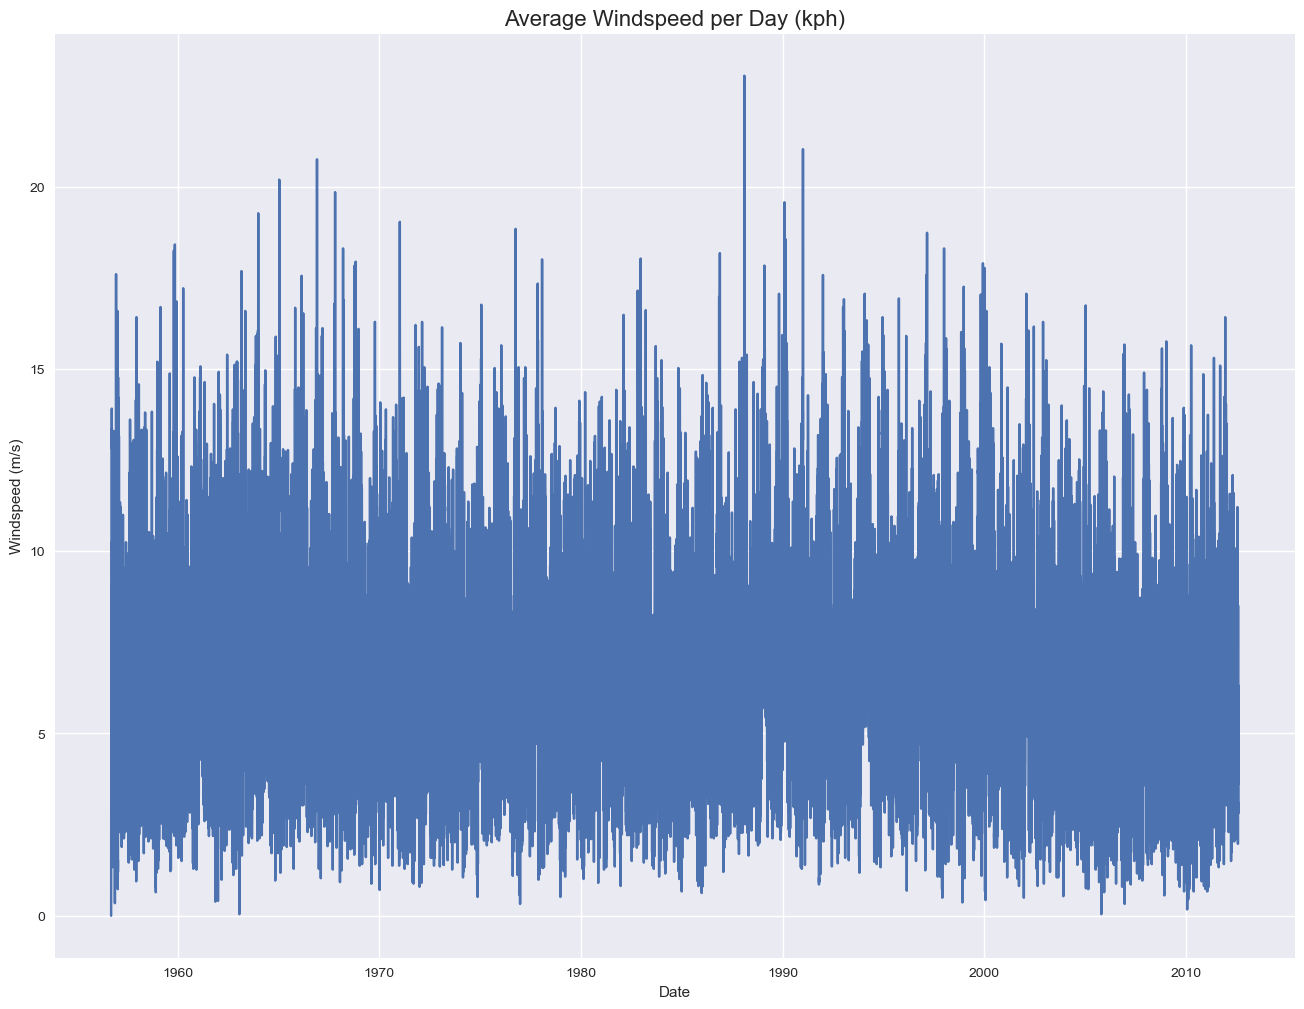

In [38]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))

sns.lineplot(data=wdsp_by_day,x=wdsp_by_day.index,y='wdsp_ms', ax=ax1)
ax1.set_ylabel('Windspeed (m/s)')
ax1.set_title('Average Windspeed per Day (kph)', fontsize=16)
ax1.set_xlabel('Date');

The above plot is too hard to read, but it can be sliced, but first need to add kilometers per hour (m/s to kph is multiplied by 3.6)

In [39]:
wdsp_by_day_max = data.resample('D').agg({'wdsp_ms':'max', 'power':'max'})
wdsp_by_day_max['wdsp_kph'] = wdsp_by_day_max['wdsp_ms'] * 3.6

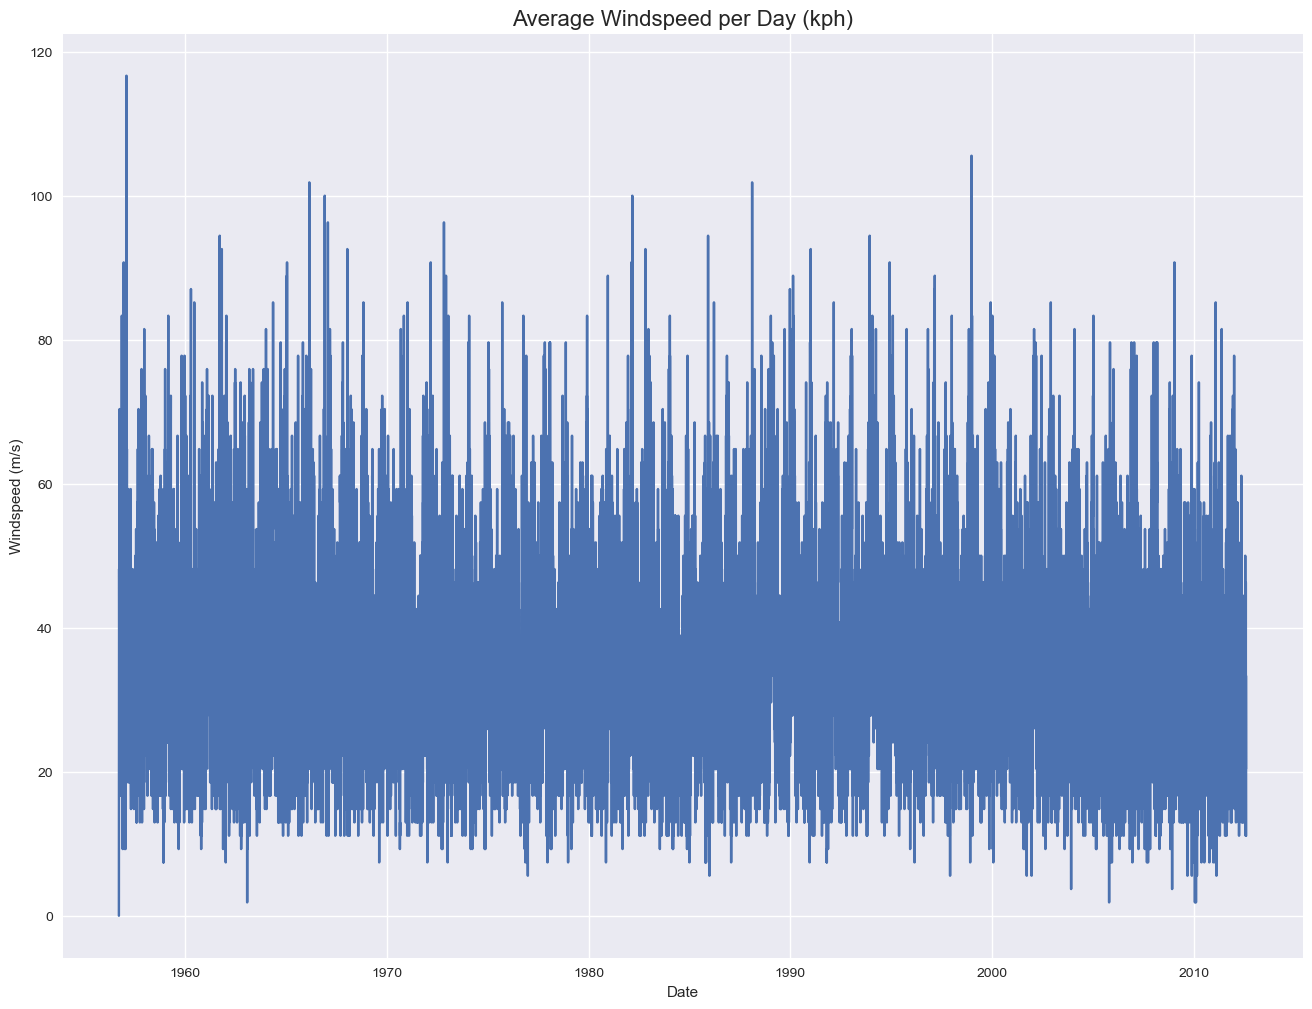

In [40]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))

sns.lineplot(data=wdsp_by_day_max,x=wdsp_by_day_max.index,y='wdsp_kph', ax=ax1)
ax1.set_ylabel('Windspeed (m/s)')
ax1.set_title('Average Windspeed per Day (kph)', fontsize=16)
ax1.set_xlabel('Date');

This can be further sliced to look for particular weather events. 

In [41]:
filtered_df = wdsp_by_day_max.loc['1998-12-20':'1998-12-31']
print(filtered_df.head())

              wdsp_ms       power   wdsp_kph
date                                        
1998-12-20   7.202216   91.530221  25.927978
1998-12-21  12.346656  461.120180  44.447962
1998-12-22  14.404432  732.241767  51.855955
1998-12-23  11.317768  355.179953  40.743965
1998-12-24  13.889988  656.555881  50.003957


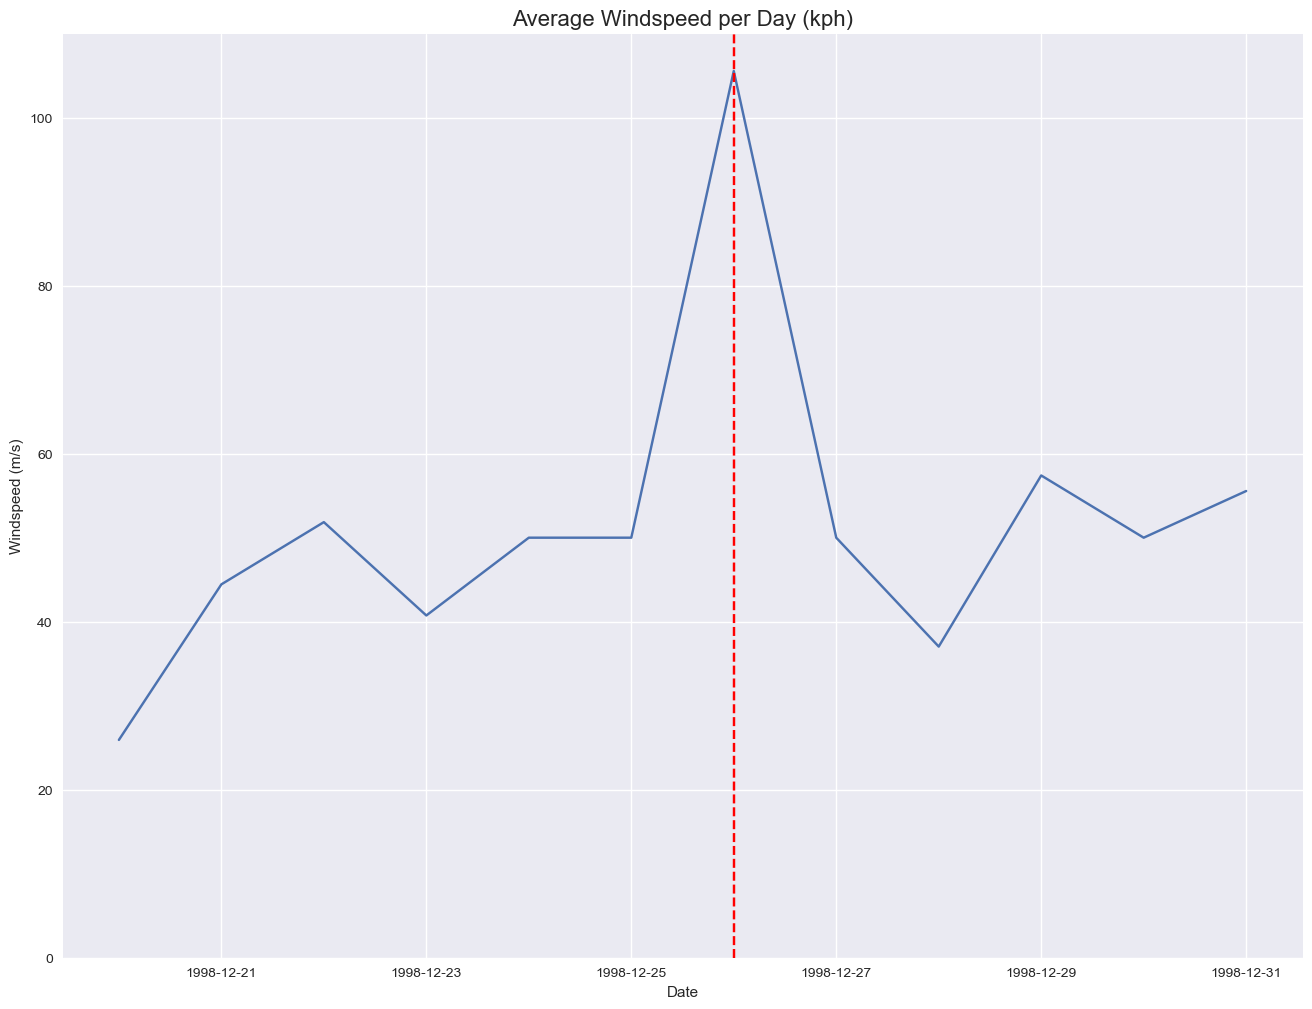

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))

sns.lineplot(data=filtered_df,x=filtered_df.index,y='wdsp_kph', ax=ax1)
ax1.set_ylabel('Windspeed (m/s)')
ax1.set_ylim([0, 110])
ax1.set_title('Average Windspeed per Day (kph)', fontsize=16)
ax1.axvline(pd.to_datetime('1998-12-26'), color='r', linestyle='--', label='1998-12-26')
ax1.set_xlabel('Date');

The plot shows a max windspeed of 105 kpm on 26-Dec-1998. This occured due to hurracine force winds in the north and northwest, but fast winds were seen in Mayo of about 61 knots or approximately 105 kpm which was found in the Met Éireann [archieves](https://www.met.ie/cms/assets/uploads/2017/08/Dec1998_Storm.pdf). 

![hurricane wins](img/hurricane.png)

Looking at temp during winter of 1963 that had coldest snap at [Belmullet](https://www.met.ie/cms/assets/uploads/2017/08/winter_1963.pdf). 

![Article on cold snap in 1963](img/Belmullet.png)

In [43]:
temp_by_day = data.resample('D').agg({'rain':'max', 'temp':'mean'})

In [44]:
filtered_df_temp = temp_by_day.loc['1963-01-01':'1963-02-20']
print(filtered_df_temp.head())

            rain      temp
date                      
1963-01-01   0.0  2.404167
1963-01-02   0.0  1.545833
1963-01-03   0.1  2.004167
1963-01-04   0.5  3.379167
1963-01-05   0.4  2.316667


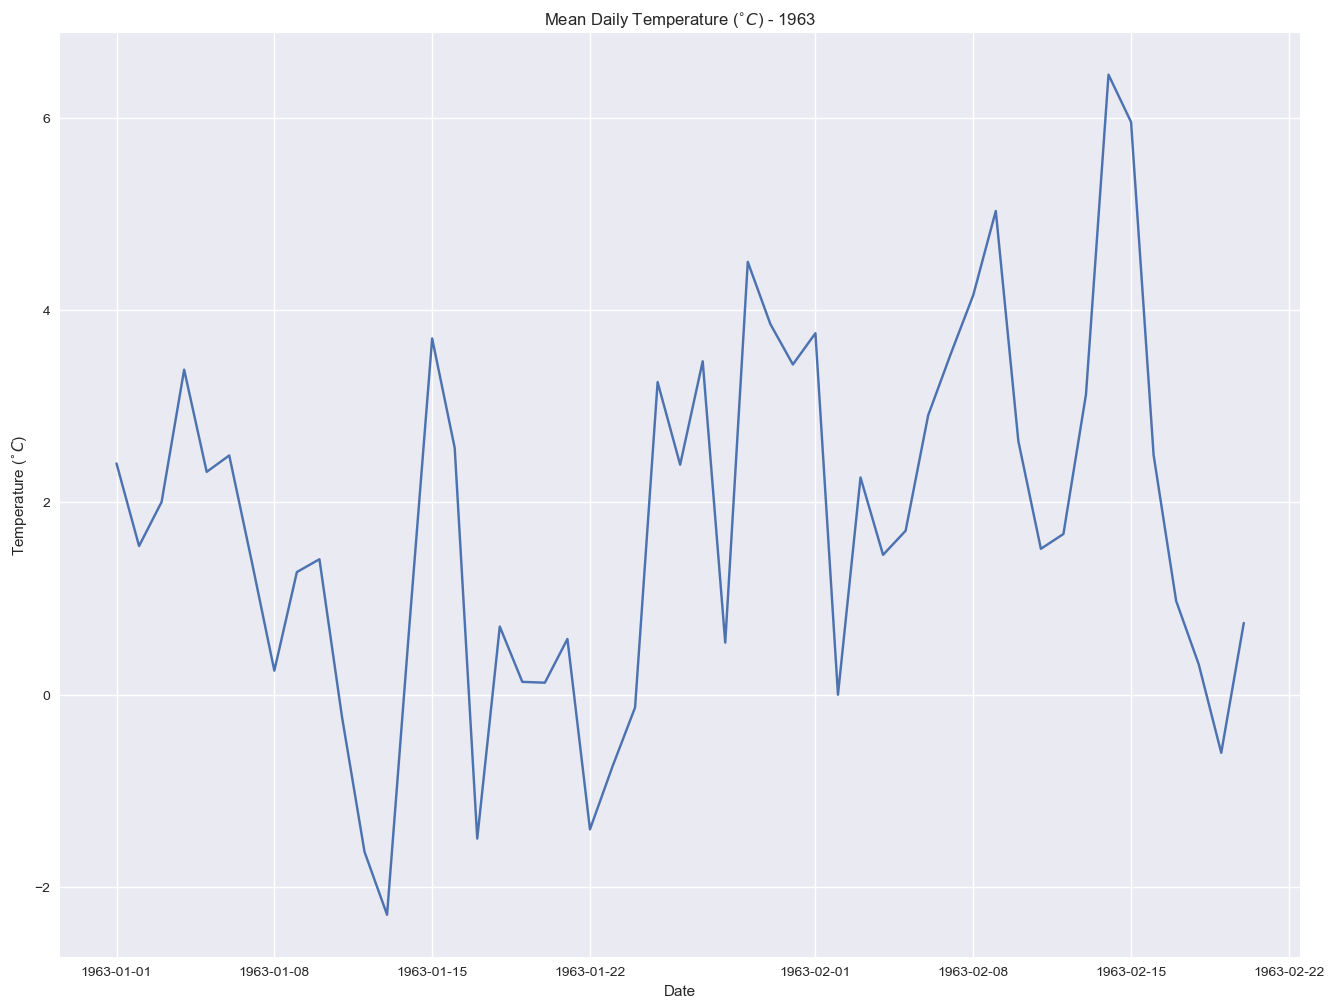

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))

ax1.set_title('Mean Daily Temperature ($^{\circ}C$) - 1963')
sns.lineplot(data=filtered_df_temp,x=filtered_df_temp.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date');

The above shows a filtered dataframe where Belmullet had the lowest mean monthly temperature of 1.2 $^{\circ}C$ since records began in the winter of 1963 which agrees with the python code below (1.3 $^{\circ}C$).

In [46]:
filtered_df_temp_jan = temp_by_day.loc['1963-01-01':'1963-01-31']
print(np.mean(filtered_df_temp_jan['temp']))

1.307392473118279


## Section 7 - Predicting rainy hours and days using Logisic Regression

While time series models can be used to predict events, a logistic regression model was chosen to classify either days or hours as being wet or dry. The classifiation used was if the column `rain` was equal to 0.0 then it was class as a dry hour/day and above that is wet. Could the other day be used to model a binary classification. 

**Logistic Regression** 

A commonly supervised regression technique is linear regression where an independent variable (or explanatory) is used to estimate dependent variable (i.e., hours of study to estimate grades). This analogy can be extended to multiple independent variables are used to estimate a dependent variable in multiple linear regression (MLS) (i.e., hours of study, extracurricular activity, number of days sick used to predict grades). The output of MLS is a continuous value (i.e., price of house or grades), in comparison, logistic regression returns the probability of a binary outcome (for example is an email spam or not).

Logistic regression (or logit regression) is a supervised classification algorithm (despite regression in the name) that is used to estimate the probability that an occurrence belongs to a classification (e.g. spam folder of email) where a threshold probability of >50% the model will predict that the occurrence belongs to the positive class (denoted as 0, i.e. normal email) or else predicts that the classification belongs to the negative class (denoted as 1, i.e. spam). The logistic function (denoted as σ) is a sigmoid function with the output bound between 0 and 1.

Logistic regression finds many applications, such as in healthcare settings to predict the likelihood that a cancer is benign or cancerous from nth variables. A database of patients with several variables is split into two with the training dataset being used to train the model while the test dataset is used for model evaluation. These variables can be measured for a new patient to predict if cancer is benign or cancerous. While this type of logistic regression is known as binary logistic regression, it can also be used to predict membership to more than two categories (i.e., is a person married, single or divorced) then multinomial logistic regression can be used. In order to use logistic regression, there are several general assumptions of the model;

- The true conditional probabilities are a logistic function of the independent variables.
- Independent variables are measured without error.
- Observations are independent.
- Errors are binomially distributed.
- Independent variables are not linear combinations of each other.
- No extraneous variables are included, and no important variables are omitted.

While a lot of data include nominal type data, logistic regression cannot use these variables for modelling (including linear regression too). To overcome this, dummy variable can be computed. One of the dummy variables of a data type can be removed so that perfect multicollinearity can be avoided. Multicollinearity can also affect the estimate of the dependent variables if the correlation coefficient of several independent variables is high (>0.8) and effects the interpretation of independent coefficients of the logistic regression model.

While `ww` and `w` could have being coded as dummy variables, they were not needed as that information was stored in other weather variables. 

In [47]:
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  sun    vis  clht  clamt month  season  year  \
date                         ...                                                
1956-09-16 15:00:00  1026.7  ...  0.1  16000   200      5   Sep  Autumn  1956   
1956-09-16 16:00:00  1026.6  ...  0.1  24000     0      4   Sep  Autumn  1956   
1956-09-16 17:00:00  1026.4  ...  0.4  19000    90      5   Sep  Autumn  1956   
1956-09-16 18:00:00  1026.5  ...  

In [48]:
data_log_reg = data.drop(columns=['ind','ind.1', 'ind.2','year', 'ind.3', 'ind.4','month','season','decade','wdsp'], axis=1)

# value counts of rain
print(data_log_reg['rain'].value_counts())


data_log_reg['target'] = data_log_reg['rain'].apply(lambda x: 1 if x == 0.0 else 0)


rain
0.0     391375
0.1      25434
0.2      14372
0.3       9881
0.4       7300
         ...  
13.2         1
18.3         1
18.5         1
17.6         1
16.3         1
Name: count, Length: 135, dtype: int64


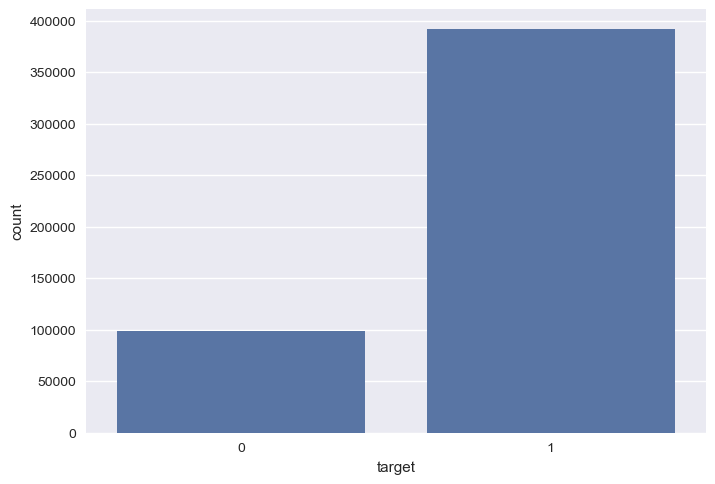

In [49]:
base_color = sns.color_palette()[0]
sns.countplot(data=data_log_reg, x='target', color = base_color);
# Where 1 is where dry and 0 is where rain

There is a class imbalance. 1 is is a dry hour with no rain while 0 is when the hour had some rain. 

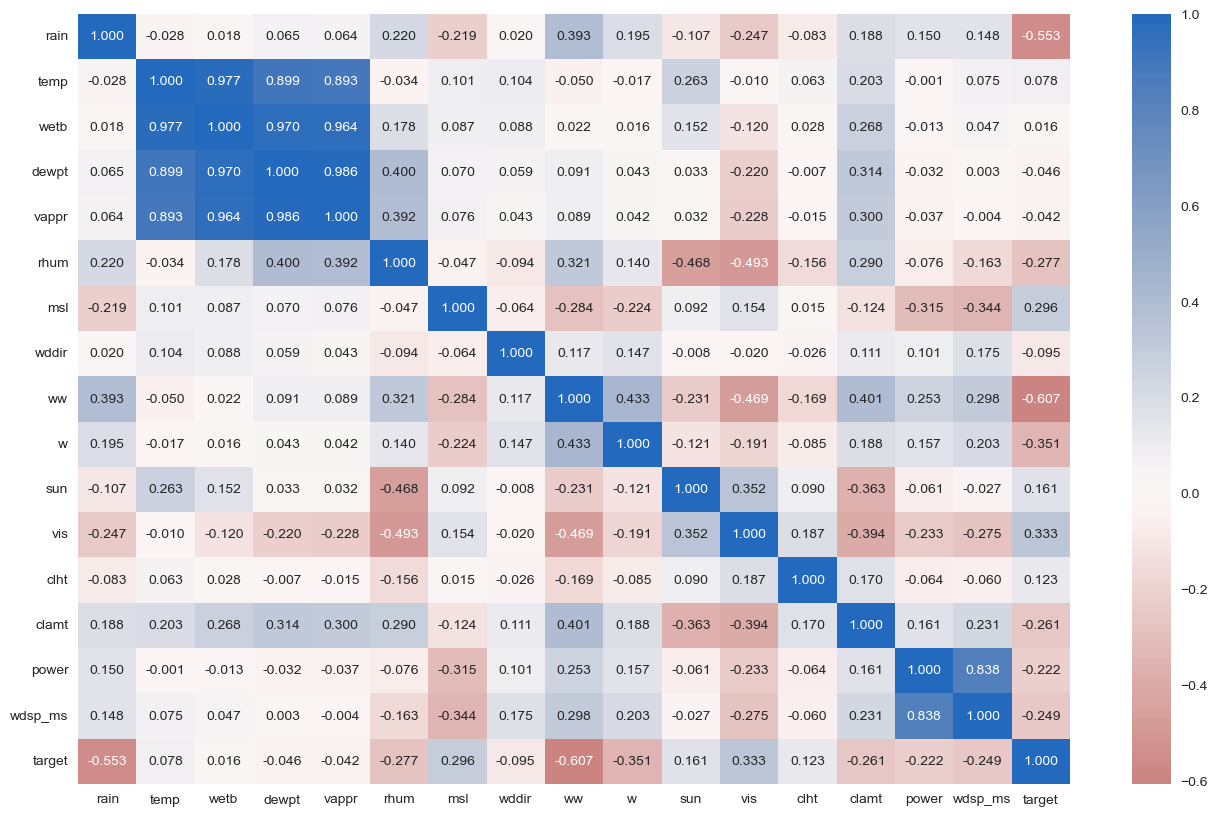

In [50]:
plt.figure(figsize = [16, 10])
sns.heatmap(data_log_reg.corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0);

The above shows multicolinearly shouldn't be a problem. A `sns.pair_plot` would have shown the bivariate plot better with the target variable, but plotting that much data was taking quite a long time to load. 

In [51]:
# drop the rain column as it is coded as the target column
data_log_reg= data_log_reg.drop(columns=['rain'], axis=1)
print(data_log_reg)

                     temp  wetb  dewpt  vappr  rhum     msl  wddir ww   w  \
date                                                                        
1956-09-16 15:00:00  14.4  12.1   10.0   12.4    76  1026.7      0  1   2   
1956-09-16 16:00:00  13.9  11.6    9.4   11.9    75  1026.6      0  1   1   
1956-09-16 17:00:00  14.2  12.0   10.0   12.3    76  1026.4      0  3   1   
1956-09-16 18:00:00  13.0  11.6   10.0   12.6    85  1026.5      0  1   1   
1956-09-16 19:00:00  12.6  11.7   11.1   13.1    90  1026.8      0  3   2   
...                   ...   ...    ...    ...   ...     ...    ... ..  ..   
2012-08-07 20:00:00  14.7  13.7   12.9   14.9    89  1019.9     30  2  11   
2012-08-07 21:00:00  13.7  12.8   12.0   14.1    90  1020.7     40  2  11   
2012-08-07 22:00:00  13.5  12.9   12.4   14.4    93  1020.6     50  2  11   
2012-08-07 23:00:00  13.3  12.8   12.4   14.4    94  1021.0     50  2  11   
2012-08-08 00:00:00  12.5  12.0   11.6   13.6    94  1021.2     60  2  11   

### Section 7.1 Initial Model 

In [52]:
log_reg = dp.BinaryLogisticRegression(data_log_reg, 'target')
log_reg.preprocess_data()
log_reg.standardize_data
log_reg.train_model()
log_reg.evaluate_model()
log_reg.print_model_summary()

c:\Users\Ellen\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8619052965734059
Confusion Matrix:
[[11942  7959]
 [ 5570 72498]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64     19901
           1       0.90      0.93      0.91     78068

    accuracy                           0.86     97969
   macro avg       0.79      0.76      0.78     97969
weighted avg       0.86      0.86      0.86     97969

Model Coefficients:
temp: 0.03681371032397323
wetb: 0.03384472923402279
dewpt: 0.04054992181263951
vappr: 0.019185568117623463
rhum: -0.10637958211698781
msl: 0.013039413799070686
wddir: -0.0028496674620880446
ww: -0.04388885642921058
w: -0.013333655408186235
sun: -0.006347502534955797
vis: -1.899841233469622e-08
clht: 0.0009267542780722633
clamt: -0.02868358634723512
power: 0.0007242755414086619
wdsp_ms: -0.1738677006175878
Model Intercept:
[-0.0016238]


A good weighed average accuracy of 0.87 was returned. Given the class imbalance is is not suprizing that the F1 score is better for dry hours (1) than wet hours (0). If all things are constant, if there is a increase in temp by one unit, the the chance of it being dry is 0.037% or 3.7%.  

In [53]:
# # Drop the current index
# data_log_reg.reset_index(drop=True, inplace=True)

# log_reg = dp.BinaryLogisticRegression(data_log_reg, 'target')
# log_reg.preprocess_data()
# log_reg.standardize_data
# log_reg.train_model()
# log_reg.evaluate_model()

### Section 7.3 - Model 2 (daily)

In [54]:
# # Weekly resampling
data_log_reg_daily = data.drop(columns=['ind','ind.1', 'ind.2','year', 'ind.3', 'ind.4','month','season','decade','wdsp', 'ww', 'w'], axis=1)
print(data_log_reg_daily.dtypes)
data_log_reg_daily = data_log_reg.resample('D').min()

# # value counts of rain
#print(data_log_reg_daily['target'].value_counts())
#print(data_log_reg_daily.head())

#data_log_reg_daily['target'] = data_log_reg_daily['rain'].apply(lambda x: 1 if x == 0.0 else 0)


rain       float64
temp       float64
wetb       float64
dewpt      float64
vappr      float64
rhum         int64
msl        float64
wddir        int32
sun        float64
vis          int32
clht         int32
clamt        int32
power      float64
wdsp_ms    float64
dtype: object


In [55]:
print(data_log_reg_daily.isnull().sum())

temp       1
wetb       1
dewpt      1
vappr      1
rhum       1
msl        1
wddir      1
ww         1
w          1
sun        1
vis        1
clht       1
clamt      1
power      1
wdsp_ms    1
target     1
dtype: int64


In [56]:
data_log_reg_daily.dropna(inplace=True) 
# removing rows with missing values durign resampling
print(data_log_reg_daily.shape)

(20415, 16)


In [57]:
print(data_log_reg_daily.isnull().sum())

temp       0
wetb       0
dewpt      0
vappr      0
rhum       0
msl        0
wddir      0
ww         0
w          0
sun        0
vis        0
clht       0
clamt      0
power      0
wdsp_ms    0
target     0
dtype: int64


In [58]:
log_reg = dp.BinaryLogisticRegression(data_log_reg_daily, 'target')
log_reg.preprocess_data()
log_reg.standardize_data
log_reg.train_model()
log_reg.evaluate_model()
log_reg.print_model_summary()

Accuracy: 0.7972079353416606
Confusion Matrix:
[[2721  260]
 [ 568  534]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      2981
         1.0       0.67      0.48      0.56      1102

    accuracy                           0.80      4083
   macro avg       0.75      0.70      0.72      4083
weighted avg       0.79      0.80      0.79      4083

Model Coefficients:
temp: -0.0901525401928354
wetb: -0.060837260984174656
dewpt: 0.18710879497299007
vappr: 0.07770287901304436
rhum: -0.029254198837351503
msl: 0.0009150990960998314
wddir: -0.004169513840586956
ww: 0.08845042330600018
w: -0.04589615691095934
sun: 0.0
vis: 7.085294684639886e-05
clht: 0.10120119610700289
clamt: -0.3541028111584253
power: -0.00030126083705455856
wdsp_ms: -0.0913946003247301
Model Intercept:
[-0.01007567]


c:\Users\Ellen\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy has gone down for daily predicting, but has increased for wet days (0), compared to dry days (1).

### Setion 7.3 Model 3
Since some variables need to be summed (`rain` and `vis`) and others need an average (`clamt`) the agg method was used to do this and resample every day. 

In [59]:
data_log_reg_daily_agg = data.resample('D').agg({'temp':'mean', 'sun':'sum', 'vis':'mean', 'clht':'mean', 'clamt':'mean', 'wddir':'mean', 'wdsp_ms':'mean', 'power':'mean', 'rain':'sum'})

In [60]:
print(data_log_reg_daily_agg.isnull().sum())

temp       1
sun        0
vis        1
clht       1
clamt      1
wddir      1
wdsp_ms    1
power      1
rain       0
dtype: int64


In [61]:
data_log_reg_daily_agg.dropna(inplace=True)

In [62]:
data_log_reg_daily_agg['target'] = data_log_reg_daily_agg['rain'].apply(lambda x: 1 if x == 0.0 else 0)
# print(data_log_reg_daily_agg['target'].value_counts())

In [63]:
print(data_log_reg_daily_agg.head())

                 temp  sun           vis       clht     clamt       wddir  \
date                                                                        
1956-09-16  12.455556  0.6  23555.555556  63.888889  5.000000    0.000000   
1956-09-17  12.729167  3.3  17458.333333  98.041667  6.541667  109.583333   
1956-09-18  14.441667  4.0  15750.000000  37.208333  6.875000  152.083333   
1956-09-19  14.945833  1.4  16000.000000  46.500000  6.541667  149.166667   
1956-09-20  15.100000  2.8  18625.000000  32.333333  6.916667  184.166667   

             wdsp_ms       power  rain  target  
date                                            
1956-09-16  0.000000    0.000000   0.0       1  
1956-09-17  3.879765   19.164696   0.0       1  
1956-09-18  4.051247   18.700485   0.0       1  
1956-09-19  5.723190   55.275881   0.0       1  
1956-09-20  9.024205  205.519092   1.0       0  


In [64]:
data_log_reg_daily_agg = data_log_reg_daily_agg.drop(columns=['rain'], axis=1)

In [65]:
print(data_log_reg_daily_agg.head())

                 temp  sun           vis       clht     clamt       wddir  \
date                                                                        
1956-09-16  12.455556  0.6  23555.555556  63.888889  5.000000    0.000000   
1956-09-17  12.729167  3.3  17458.333333  98.041667  6.541667  109.583333   
1956-09-18  14.441667  4.0  15750.000000  37.208333  6.875000  152.083333   
1956-09-19  14.945833  1.4  16000.000000  46.500000  6.541667  149.166667   
1956-09-20  15.100000  2.8  18625.000000  32.333333  6.916667  184.166667   

             wdsp_ms       power  target  
date                                      
1956-09-16  0.000000    0.000000       1  
1956-09-17  3.879765   19.164696       1  
1956-09-18  4.051247   18.700485       1  
1956-09-19  5.723190   55.275881       1  
1956-09-20  9.024205  205.519092       0  


In [66]:
log_reg = dp.BinaryLogisticRegression(data_log_reg_daily_agg, 'target')
log_reg.preprocess_data()
log_reg.standardize_data
log_reg.train_model()
log_reg.evaluate_model()
log_reg.print_model_summary()

Accuracy: 0.7999020328190056
Confusion Matrix:
[[2754  227]
 [ 590  512]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2981
           1       0.69      0.46      0.56      1102

    accuracy                           0.80      4083
   macro avg       0.76      0.69      0.71      4083
weighted avg       0.79      0.80      0.79      4083

Model Coefficients:
temp: 0.09157183368677121
sun: 0.052930346014391116
vis: 1.806121001308747e-05
clht: 0.014186123336368575
clamt: -0.2510302426740556
wddir: -0.008696412173309924
wdsp_ms: 0.059841601244188726
power: -0.006841264184160168
Model Intercept:
[0.20891437]


c:\Users\Ellen\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This model behaved similar to previous one. 

## Section 8 - Time Series Analysis

Based on the logistic regression model, a time series analysis will be conducted on the temperature data to see if this can be predicted. Given there is so much data, the data will be resampled to monthly data to make it easier to work with. 
The a test for stationarity will be conducted using the Augmented Dickey-Fuller test. This test for stationarity is important as time series analysis requires the data to be stationar to reduce variance. 

In [67]:
data_monthly_model = data[['temp','rain']].resample('ME').mean()

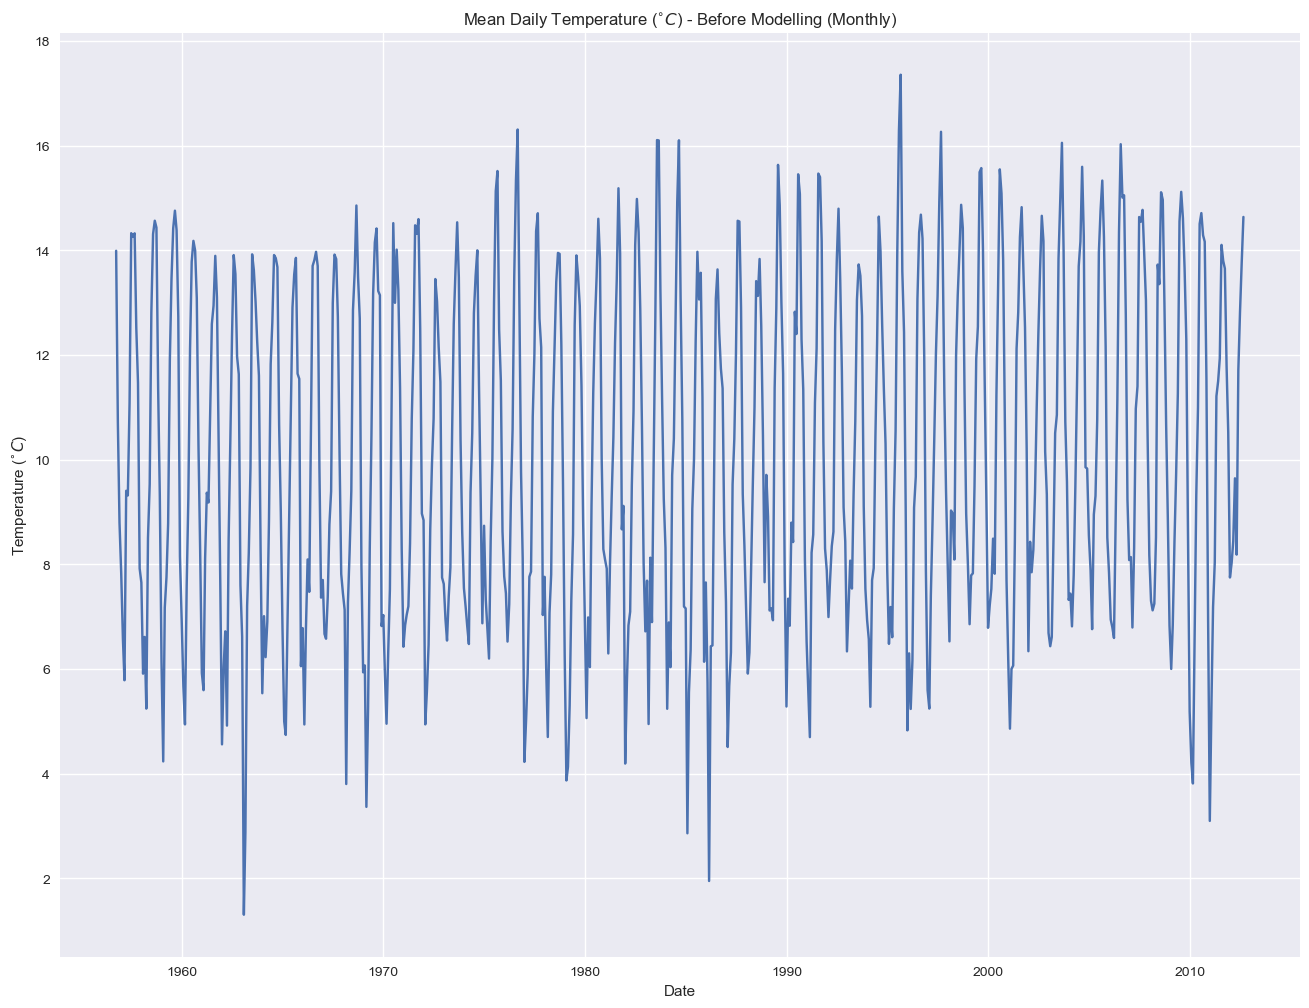

In [68]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))

ax1.set_title('Mean Daily Temperature ($^{\circ}C$) - Before Modelling (Monthly)')
sns.lineplot(data=data_monthly_model,x=data_monthly_model.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date');

In [69]:
result = adfuller(data_monthly_model['temp'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.26774973720566
p-value: 0.0005049371172654977


Since the p-value is less than 0.05, we can reject the null hypothesis that the data is non-stationary. Therefore, the data is stationary and we can proceed with the ARIMA model. If the data was non-stationary, then it would contain variance and it would need to be removed. 


In [70]:
train = data_monthly_model['temp']
print(train.tail())

date
2012-04-30     8.188611
2012-05-31    11.715860
2012-06-30    12.813611
2012-07-31    13.766398
2012-08-31    14.640828
Freq: ME, Name: temp, dtype: float64


In [71]:
model = auto_arima(train, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2672.574, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5082.979, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2851.915, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4296.433, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2714.531, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2737.353, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2221.165, Time=1.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2717.968, Time=0.38 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2115.583, Time=1.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.37 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=1.59 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=1.87 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2045.598, Time=1.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2655.256, Time=0.71 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=2647.4

Using `auto_arima` to cycle through the best model type for the data. It found model type `ARIMA(3,0,3)(0,0,0)[0]` was the best, so that will be used for forecasting. 

In [72]:
forecast = model.predict(n_periods=36)
print(forecast)

2012-09-30    13.448289
2012-10-31    12.060973
2012-11-30    10.384291
2012-12-31     8.866903
2013-01-31     7.907439
2013-02-28     7.749591
2013-03-31     8.420129
2013-04-30     9.725553
2013-05-31    11.307253
2013-06-30    12.739512
2013-07-31    13.643639
2013-08-31    13.787630
2013-09-30    13.145194
2013-10-31    11.899169
2013-11-30    10.389387
2013-12-31     9.019787
2014-01-31     8.150122
2014-02-28     8.001264
2014-03-31     8.599004
2014-04-30     9.770581
2014-05-31    11.193961
2014-06-30    12.485869
2014-07-31    13.304548
2014-08-31    13.439724
2014-09-30    12.866126
2014-10-31    11.746988
2014-11-30    10.387476
2014-12-31     9.151258
2015-01-31     8.362992
2015-02-28     8.222858
2015-03-31     8.755597
2015-04-30     9.806976
2015-05-31    11.087818
2015-06-30    12.253061
2015-07-31    12.994290
2015-08-31    13.120938
Freq: ME, dtype: float64


             Forecast
2012-09-30  13.448289
2012-10-31  12.060973
2012-11-30  10.384291
2012-12-31   8.866903
2013-01-31   7.907439
2013-02-28   7.749591
2013-03-31   8.420129
2013-04-30   9.725553
2013-05-31  11.307253
2013-06-30  12.739512
2013-07-31  13.643639
2013-08-31  13.787630
2013-09-30  13.145194
2013-10-31  11.899169
2013-11-30  10.389387
2013-12-31   9.019787
2014-01-31   8.150122
2014-02-28   8.001264
2014-03-31   8.599004
2014-04-30   9.770581
2014-05-31  11.193961
2014-06-30  12.485869
2014-07-31  13.304548
2014-08-31  13.439724
2014-09-30  12.866126
2014-10-31  11.746988
2014-11-30  10.387476
2014-12-31   9.151258
2015-01-31   8.362992
2015-02-28   8.222858
2015-03-31   8.755597
2015-04-30   9.806976
2015-05-31  11.087818
2015-06-30  12.253061
2015-07-31  12.994290
2015-08-31  13.120938


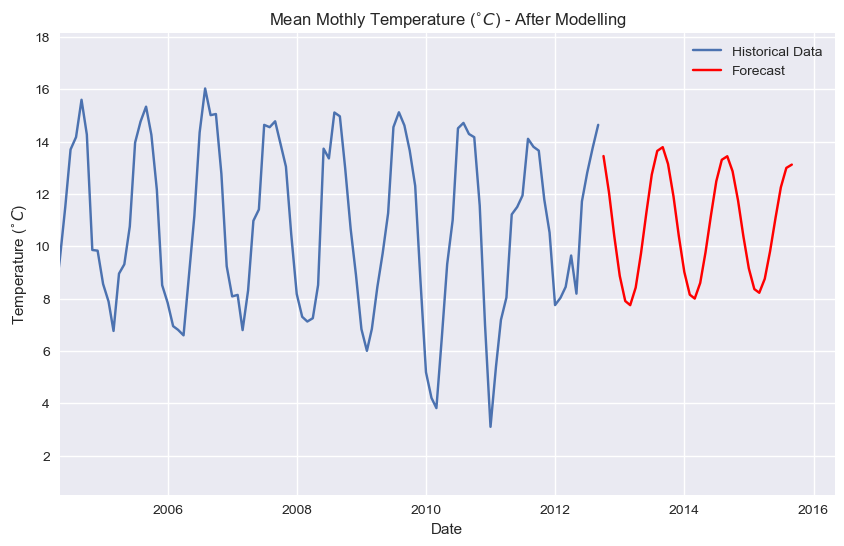

In [73]:
forecast_index = pd.date_range(start=data_monthly_model.index[-1] + pd.DateOffset(months=1), periods=36, freq='ME')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.title('Mean Mothly Temperature ($^{\circ}C$) - After Modelling')
plt.plot(data_monthly_model['temp'], label='Historical Data')
plt.plot(forecast_df, label='Forecast', color='red')
plt.xlim(pd.to_datetime('2004-04-30'), pd.to_datetime('2016-04-30'))
plt.ylabel('Temperature ($^{\circ}C$)')
plt.xlabel('Date')
plt.legend(); 

# Print forecast
print(forecast_df)

The model was ok, it correctly predicted the seasonality of temperature until late 2015 (3 years of forecasting), but there is not much variation when looking at the historical data. In winter of each forcasted year the min temperature is increasing and the max temperature is decreasing. 

## Section 9 - Final exported dataset

In [74]:
data.to_csv('data\\hly2375_cleaned.csv', index=True)

## Section 10 - References 
[Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610)